# Read and process groundwater data ILVO agricultural park

Load essential Python modules

In [3]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#from pandasql import sqldf
import datetime
import csv
from tqdm.notebook import tqdm
#!pip install traces

## Read raw data from excell files and plot for quick inspection

### Read Climate Data  (www.dacom.nl)

In [7]:
path1 = os.getcwd()
path = os.path.join(path1, 'raw_data', 'info')
file = os.path.join(path, 'weather_data.csv')

#climate data from  www.dacom.nl
clim=pd.read_csv(file,sep=',', parse_dates=[['date','time']],dayfirst=True)
#clim['date_time']=pd.to_datetime(clim['date_time'], unit='s')
clim2=clim.set_index('date_time')
climdaily=clim2.resample('D').agg({'precipitation': np.sum})#, 'air_temperature': np.mean,'rel_humidity': np.mean})
#climdaily.reset_index().plot(kind='scatter', x='date_time', y='precipitation')


### Read data

In [9]:
datapath =  os.path.join(path1, 'raw_data')
baro_ind='AP825'
xls_files = glob.glob(os.path.join(datapath, "*.xlsx")) # change to csv 
#barometer felt down in pipe on   '2022-05-25 07:25:00'  
#loop over the list of xls files
ind = 0
diver_names={}
alldf={}
for i,f in tqdm(enumerate(xls_files),total=len(xls_files)):
    # read the csv file
    df = pd.read_excel(f)
    # remove double copied parts of the logged data from the raw data files
    df=df.drop_duplicates()  
    # print the location and filename for check
    #print('Location:', f)
    #print('File Name:', f.split("\\")[-1])
    df=df.assign(Date=df.TimeStamp.dt.round('H'))
    
    df['Date']=pd.to_datetime(df['Date'],dayfirst=True)
    df=df.loc[(df['TimeStamp'] < '2022-05-25 07:25:00')]
    dfdaily=df.resample('D', on = 'Date').mean()

    # merge all data in 1 dataframe
    if baro_ind in f:
        baro_data=df
        baro_data=baro_data.loc[(baro_data['TimeStamp'] < '2022-05-25 07:25:00')]
        #baro_data=baro_data.append.df# this tests for substrings
    if ind == 0:
        #First data frame loaded
        GWdata = df
        GWdata_daily = dfdaily
    else:
        # Paste the rest to this dataframe
        GWdata = pd.concat([GWdata,df],axis=0).reset_index(drop=True)
        GWdata_daily = pd.concat([GWdata_daily,df],axis=0).reset_index(drop=True)
        alldf[i]=df
        alldf[i]=alldf[i].loc[(alldf[i]['TimeStamp'] < '2022-05-25 07:25:00')]
        GWdata
    ind = ind + 1 
#Remove empty columns from the dataframe    
GWdata.drop(labels=['Conductivity', 'WaterLevel','WaterLevelReference'], axis=1)

# Read manually measured water dephts for inspection of the data    
path_obs=os.path.join(path1, 'raw_data', 'info')
file_obs = os.path.join(path_obs, 'manual_check_water_depth.xlsx')
df_info = pd.read_excel(file_obs)
df_info['Time']=pd.to_datetime(df_info['Time'],dayfirst=True)
(df_info.Time)
df_info2=df_info[df_info.Time.notnull()]
df_info2=df_info2.reset_index(drop=True)
df_info2["Depth in cm"] = (-df_info2["Depth in cm"])*(.01)    
groups = df_info2.groupby('SerialNumber')
colors = {'AP689':'#1f77b4', 'AG083':'#ff7f0e','AZ649': '#2ca02c','CA186': '#d62728', 'CA969':'#9467bd','AP707': '#8c564b'}


  0%|          | 0/28 [00:00<?, ?it/s]

## Processing steps

Dataset Processing explanation						
1. Collect total pressure (TP) from divers		 (cmH2O)				
2. Calculate water pressure (WP) = TP - AP		 (cmH2O)		
3. Calculate hydraulic gradient. Take the timestep "t" at which a manual measurement is realized and calculate the hydraulic head						
     - H(t) = TW-WD(t)						
     - H (t+1) = H(t)  + (WP (t+1) - WP (t))/100						
																	
With :											
AP= Air Pressure (cmH20)											
H=Hydraulic Head (mTAW)						
TW=Top well Elevation (mTAW)						
WD=Water depth from the top well (m)												
						
| well   name | well   name | soil elevation(mTAW) | well height above the ground (m) | Top well (mTAW) |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|
|  AP707  |   Remue_6   |         18,15        |                 1                |      19,15      |
|   CA969   |   Remue_5   |         14,69        |               1,06               |      15,75      |
|   CA186  |   Remue_4   |         13,5         |               1,15               |      14,65      |
|   AZ649   |   Remue_3   |         14,75        |                 1                |      15,75      |
|   AG083  |   Remue_2   |         13,53        |                1,2               |      14,73      |
|   AP689   |   Remue_1   |         14,34        |               1,13               |      15,47      |

C:\Users\amehmandoostkotlar\AppData\Local\Temp\ipykernel_13428\1760473707.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadaily['TimeStamp']=datadaily['time']


0


C:\Users\amehmandoostkotlar\AppData\Local\Temp\ipykernel_13428\1760473707.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadaily['TimeStamp']=datadaily['time']


1


C:\Users\amehmandoostkotlar\AppData\Local\Temp\ipykernel_13428\1760473707.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datanew["WaterPress"].loc[datanew["time"] == '2022-05-12 10:25:00']=list(datanew["WaterPress"].loc[datanew["time"] == '2022-05-12 09:25:00'])[0]
C:\Users\amehmandoostkotlar\AppData\Local\Temp\ipykernel_13428\1760473707.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datanew["WaterPress"].loc[datanew["time"] == '2022-05-12 11:25:00']=list(datanew["WaterPress"].loc[datanew["time"] == '2022-05-12 09:25:00'])[0]
C:\Users\amehmandoostkotlar\AppData\Local\Temp\ipykernel_13428\1760473707.py:69: S

2


C:\Users\amehmandoostkotlar\AppData\Local\Temp\ipykernel_13428\1760473707.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadaily['TimeStamp']=datadaily['time']


3


C:\Users\amehmandoostkotlar\AppData\Local\Temp\ipykernel_13428\1760473707.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadaily['TimeStamp']=datadaily['time']


4


C:\Users\amehmandoostkotlar\AppData\Local\Temp\ipykernel_13428\1760473707.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadaily['TimeStamp']=datadaily['time']


5


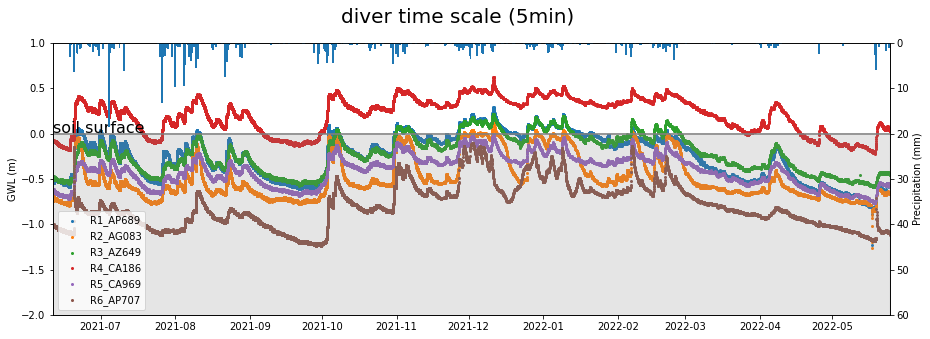

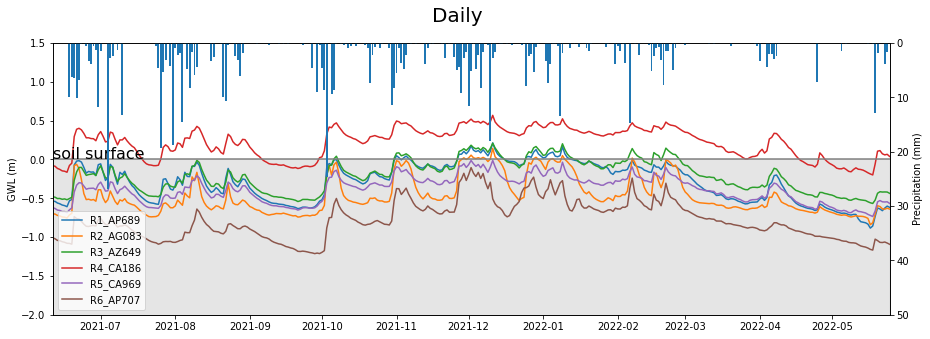

rem6-2
AP707 - AG083 / 183.7
rem5-2
CA969 - AG083 / 103
rem3-2
AZ649 - AG083 / 71.4
rem6-3
AP707 - AZ649 / 112.3
rem4-2
CA186 - AG083 / 49.4
rem1-3
AP689 - AZ649 / 338.8
rem5-3
CA969 - AZ649 / 71.7


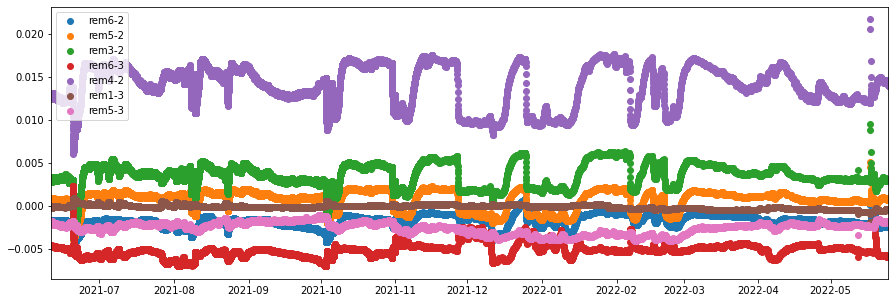

In [12]:
wellinfo = { 'SerialNumber' : ['AP689','AG083','AZ649','CA186','CA969','AP707'], 
            'WellName' : {'Remue_1','Remue_2','Remue_3','Remue_4','Remue_5','Remue_6'},
            'lgnds' : ['R1_AP689','R2_AG083','R3_AZ649','R4_CA186','R5_CA969','R6_AP707'],
            'soil_mTAW' : [14.34, 13.53, 14.75, 13.50, 14.69, 18.15],
            'well_height_m' : [1.13, 1.20, 1.00, 1.15, 1.06, 1.00],
            'initials' : [14.34+1.13-1.67, 13.53+1.20-1.9, 14.75+1.00-1.48, 13.50+1.15-1.23, 14.69+1.06-1.68, 18.15+1.00-2.01],
            'measure_time':['2021-06-11 11:30:00','2021-06-11 11:00:00',
                        '2021-06-11 10:40:00','2021-06-11 11:00:00',
                        '2021-06-11 10:50:00','2021-06-11 10:40:00'],
           'long':[108830.3064,109119.0567,109065.0528,109069.8331,109016.2142,108979.9484],
           'lat':[184839.1819,185036.6799,185083.4755,185033.7389,185031.9617,185156.5789]}
#,'AG083','AZ649','CA186','CA969','AP707'
date1=datetime.date(2021,6,11)
date2=datetime.date(2022,5,25)
baro_data=GWdata[GWdata.SerialNumber == 'AP825'].reset_index( drop=True)

df1=[]
df2=[]
df3=[]
column_names = ["time","WaterPress","WaterPressIntp"]
datanew = pd.DataFrame(columns = column_names)
 
dataall={}
baro_press_int={}  #interpolated barometric pressure head for the timestamps of each piezometer 
#baro_time_int={}  #time stamps barometric pressure head for the timestamps of each piezometer 
WaterPressure={}   #pressure heads recorded by divers for 6 piezometers
alldata={}         #hydrauli head of each piezo
GWL={}             #groundwater level of each piezo
sumrows={}
piezo_P={}
#difw={}
GWLdaily={}
interp="piezo_data" # "baro_data" or "piezo_data" if it is interpolated based on baro time vector they all have the same t axis else each piezo has its own t axis
fig,  ax = plt.subplots(figsize=(15,5))
fig2, ax2= plt.subplots(figsize=(15,5))

for f,i in enumerate(wellinfo['SerialNumber']):
    #print(i)

    column_names = ["time","WaterPress","WaterPressIntp"]
    datanew = pd.DataFrame(columns = column_names)
    data=GWdata[GWdata.SerialNumber == i].reset_index()
    #print(data)
    data=data[data['Pressure'] > 1100].reset_index() # to remove outliers ?
    data = data.sort_values(by=['TimeStamp'],ascending=True)
    dataall[i]=data
    data.to_csv(wellinfo['lgnds'][f]+'.csv')
    #str(data.iloc[1,4]).split(" ")[0]+'T'+str(data.iloc[1,4]).split(" ")[1]+'.000'+'+1:00'
    baro_press_int[i]=pd.Series(np.interp(data.TimeStamp,baro_data.TimeStamp,baro_data.Pressure))#interpolation based on each piezo time vector
    piezo_P[i]=pd.Series(np.interp(baro_data.TimeStamp.reset_index( drop=True),data.TimeStamp,data.Pressure)) #interpolation based on barometric time vector
    
    if interp=="piezo_data":
        WaterPressure[i]=piezo_P[i]-baro_data.Pressure.reset_index()['Pressure']#corrected by barometric pressure
        taxis=baro_data.TimeStamp
        data["WaterPress"]=WaterPressure[i]
        datanew["WaterPress"]=WaterPressure[i]
        datanew["time"]=baro_data.TimeStamp
        datanew["WaterPressIntp"]=piezo_P[i]
    elif interp=="baro_data":
        WaterPressure[i]=baro_press_int[i]#-baro_press_int[i]
        taxis=data.TimeStamp
        data["WaterPress"]=WaterPressure[i]
        datanew["WaterPress"]=WaterPressure[i]
        datanew["time"]=baro_data.TimeStamp
        datanew["WaterPressIntp"]=piezo_P[i]
    if i=='AZ649':
        datanew["WaterPress"].loc[datanew["time"] == '2022-05-12 10:25:00']=list(datanew["WaterPress"].loc[datanew["time"] == '2022-05-12 09:25:00'])[0]
        datanew["WaterPress"].loc[datanew["time"] == '2022-05-12 11:25:00']=list(datanew["WaterPress"].loc[datanew["time"] == '2022-05-12 09:25:00'])[0]
        datanew["WaterPress"].loc[datanew["time"] >= '2022-05-12 12:25:00']=datanew["WaterPress"].loc[datanew["time"] >= '2022-05-12 12:25:00']+100

   
    ##here if correct by barometric results of GW will change
    deltawaterpres=np.append(0,(np.diff(datanew["WaterPress"].array)/100))
    deltawaterpres[0]=wellinfo['initials'][f]+deltawaterpres[0]
    datanew["diffWaterPress"]=deltawaterpres
    datanew["diffwat"]=(deltawaterpres.cumsum())
    #HydHead[i]=np.append(wellinfo['initials'][f],diffwat)
    #datanew["HydHead"]=HydHead[i]
    datanew["GWdepths"]=wellinfo['soil_mTAW'][f]- datanew["diffwat"]
    GWL[i]=datanew["GWdepths"]
    datanew = datanew.drop_duplicates(subset='time').reset_index(drop=True)
    alldata[i]=datanew
    #correct the Remue 3 with broken pipe
    #if i=='AZ649':
       # alldata[i]["GWdepths"].loc[alldata[i]["time"] == '2022-05-12 10:25:00']=list(alldata[i]["GWdepths"].loc[alldata[i]["time"] == '2022-05-12 09:25:00'])[0]
       # alldata[i]["GWdepths"].loc[alldata[i]["time"] == '2022-05-12 11:25:00']=list(alldata[i]["GWdepths"].loc[alldata[i]["time"] == '2022-05-12 09:25:00'])[0]
        #alldata[i]["GWdepths"].loc[alldata[i]["time"] >= '2022-05-12 12:25:00']=alldata[i]["GWdepths"].loc[alldata[i]["time"] >= '2022-05-12 12:25:00']-0.92
    #print(datanew)
    ##daily data
    datadaily=alldata[i][["time","WaterPress"]]
    
    #print(datadaily)
    datadaily['TimeStamp']=datadaily['time']
    datadaily=datadaily.resample('D', on = 'TimeStamp').mean()
    #delPdaily=(np.diff(datadaily.Pressure.array)/100)
    delPdaily=np.append(0,(np.diff(datadaily["WaterPress"].array)/100))
    delPdaily[0]=wellinfo['initials'][f]+delPdaily[0]
    datadaily["diffWaterPress"]=delPdaily
    datadaily["diffwat"]=(delPdaily.cumsum())
    #HyHeaddaily=np.append(wellinfo['initials'][f],difPdaily[1:])
    datadaily["GWdepths"]=wellinfo['soil_mTAW'][f]- datadaily["diffwat"]
    #GWdepdaily=wellinfo['soil_mTAW'][f]-HyHeaddaily
    #GWLdaily[i]=datadaily["GWdepths"]
    #print(data.SerialNumber.unique())
    print(f)
    # create data for DOV
    #find a way faster than this loop
    for index, row in data.iterrows():
        df1.append([data.iloc[index,4].strftime('%Y-%m-%dT%H:%M:%S.000+01:00'),round(-GWL[i][index]+wellinfo['soil_mTAW'][f],2),1])
    #data['dovTime'] = data['Timestamp'].dt.strftime('%Y-%m-%d ...')
    #data['dovGW'] = ...
    #data['one'] = 1
    #data[['dovTime', 'dovGW', 'one']].to_csv(...index=False)
    # df1.append([str(data.iloc[index,4].).split(" ")[0:11]+'T'+str(data.iloc[index,4]).split(" ")[12:22]+'.000'+'+01:00',
           #    round(-GWL[i][index]+wellinfo['soil_mTAW'][f],2),1])
            #df1.append([str(data.iloc[index,4].strftime('yyyy-MM-dd'T'HH:mm:ss.SSSz'),
           #    round(-GWL[i][index]+wellinfo['soil_mTAW'][f],2),1])
            
    
    df2=pd.DataFrame (df1)
    df2.to_csv(wellinfo['lgnds'][f]+'_5min_DOV.csv', index=False,header=False) 
    df3=[]
    num_index=0
    datadaily1=datadaily.reset_index(drop=True)
    for index, row in datadaily.iterrows():
        df3.append([datadaily.index[num_index].strftime('%Y-%m-%dT%H:%M:%S.000+01:00'),round(-datadaily["GWdepths"][num_index]+wellinfo['soil_mTAW'][f],2),1])
        #df3.append(str(datadaily.index[num_index])[0:10]+'T'+str(datadaily.index[num_index])[11:22]+'.000'+'+01:00,'
              #+str(round(-GWLdaily[i][num_index]+wellinfo['soil_mTAW'][f],2))+',1')
        num_index=num_index+1
        
    df3=pd.DataFrame (df3)
    df3.to_csv(wellinfo['lgnds'][f]+'_daily_DOV.csv', index=False,header=False) 
    #datadaily["GWdepth"]=GWdepdaily[i]
    ##plot hourly ax, daily ax2
    data_obs=df_info[df_info.SerialNumber == i].reset_index()
    ax.scatter(alldata[i]["time"],-alldata[i].GWdepths,s=4)
    ax2.plot(datadaily.index.values,-datadaily["GWdepths"])
    #plt.ylim(-1.5,0)
ax.set_ylim([-2,1.])

ax.set_ylabel('GWL (m)')
fig.suptitle('diver time scale (5min)', fontsize=20)
#print()
ax.legend(wellinfo['lgnds'],loc='lower left')
ax.scatter(df_info2.Time, df_info2.iloc[:,3], 70,marker="o", facecolors='none',edgecolors=df_info2['SerialNumber'].map(colors))
ax2.scatter(df_info2.Time, df_info2.iloc[:,3], 70,marker="o", facecolors='none',edgecolors=df_info2['SerialNumber'].map(colors))

axb=ax.twinx()
axb.bar(clim['date_time'],clim.precipitation)
ax.set_xlim([date1,date2])
ax2.legend(wellinfo['lgnds'],loc='lower left')
ax.axhline(y=0,color='grey',linestyle='-')
ax.fill_between(alldata[i]["time"],0,-150,color='grey',alpha=.2)
ax.text(alldata[i]["time"][2],0.01,'soil surface',fontsize=16)
axb.set_ylim([0, 60])
axb.invert_yaxis()
axb.set_ylabel('Precipitation (mm)')

axc=ax2.twinx()
axc.bar(climdaily.index.values,climdaily.precipitation)

fig2.suptitle('Daily', fontsize=20)

axc.set_ylim([0, 50])
axc.invert_yaxis()
ax2.set_ylim([-2,1.5])
ax2.set_xlim([date1,date2])
axc.set_ylabel('Precipitation (mm)')
ax2.set_ylabel('GWL (m)')
#ax2.axes.xaxis[2].set_visible(False)
ax2.axhline(y=0,color='grey',linestyle='-')
ax2.fill_between(alldata[i]["time"],0,-150,color='grey',alpha=.2)
ax2.text(alldata[i]["time"][2],0.01,'soil surface',fontsize=16)

plt.show()

gradients={}

pairs=['rem6-2','rem5-2','rem3-2','rem6-3','rem4-2','rem1-3','rem5-3']
dist=[183.7,103,71.4,112.3,49.4,338.8,71.7]
fig, ax3 = plt.subplots(figsize=(15,5))


for j,k in enumerate(pairs):
    print(k)
    #print(j)
    print(wellinfo['SerialNumber'][pd.to_numeric(pairs[j][3])-1],'-',wellinfo['SerialNumber'][pd.to_numeric(pairs[j][5])-1],'/',dist[j])
    p1=pd.to_numeric(pairs[j][5])-1
    p2=pd.to_numeric(pairs[j][3])-1
    #gradients[k]=(pd.Series(np.interp(dataall[wellinfo['SerialNumber'][p2]].TimeStamp,dataall[wellinfo['SerialNumber'][p1]].TimeStamp,dataall[wellinfo['SerialNumber'][p1]].Pressure))-dataall[wellinfo['SerialNumber'][p2]].Pressure)/dist[j]/100
    gradients[k]=(alldata[wellinfo['SerialNumber'][p1]]["GWdepths"]-alldata[wellinfo['SerialNumber'][p2]]["GWdepths"])/dist[j]
    ax3.scatter(alldata[wellinfo['SerialNumber'][p2]]["time"],gradients[k])
ax3.set_xlim([date1,date2])

ax3.legend(pairs,loc='upper left')


